# Calculating Tommy's Portfolio Using Non-Negative Least-Squares

- This allocation is the best one for a number of reasons:
    - 1. No leverage
    - 2. No high turnover
    - 3. All long positions

- Essentially, this is the most realistic, mathematically correct way to optimize your portfolio. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import matplotlib as mpl
import seaborn as sns
import scipy as scs
import math
import yfinance as yf
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn")
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline



In [106]:
def regression_based_performance(factor,fund_ret,rf,constant = True):
    """ 
        Returns the Regression based performance Stats for given set of returns and factors
        Inputs:
            factor - Dataframe containing monthly returns of the regressors
            fund_ret - Dataframe containing monthly excess returns of the regressand fund
            rf - Monthly risk free rate of return
        Output:
            summary_stats - (Beta of regression, treynor ratio, information ratio, alpha). 
    """
    if constant:
        X = sm.tools.add_constant(factor)
    else:
        X = factor
    y=fund_ret
    model = sm.OLS(y,X,missing='drop').fit()
    
    if constant:
        beta = model.params[1:]
        alpha = round(float(model.params['const']),6)
        
    else:
        beta = model.params
    treynor_ratio = ((fund_ret.values-rf.values).mean()*12)/beta[0]
    tracking_error = (model.resid.std()*np.sqrt(12))
    if constant:        
        information_ratio = model.params[0]*12/tracking_error
    r_squared = model.rsquared
    if constant:
        return (beta,treynor_ratio,information_ratio,alpha,r_squared,tracking_error)
    else:
        return (beta,treynor_ratio,r_squared,tracking_error)

# Getting the Data

In [89]:
tickers = "AAPL MSFT GS VYM XOM JPM WTRG OXY ^GSPC BUD VNQ HD NFLX"
start = "2003-01-01"
end = "2022-12-01"
rf = pd.DataFrame(yf.download('^IRX', start = start, interval = '1mo', end = end)['Adj Close'])
rf.dropna(inplace = True)
rf = rf *(10**-2)
rf.columns = ['3M Treasury']
adj_close = pd.DataFrame(yf.download(tickers, start,interval = '1mo', end = end)["Adj Close"])
adj_close.dropna(inplace = True)
adj_close.columns = ["Apple", "Budweiser", "Goldman", "Home Depot" ,"JP Morgan", "Microsoft", "Netflix", "Occidental Petroleum","Vanguard Real Estate", "Vanguard High Dividend","Essential Utilities", "Exxon", "S&P 500"]
rets = adj_close.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  13 of 13 completed


In [92]:
rets = rets.join(rf, how = 'inner')

In [93]:
rets.head()

,Apple,Budweiser,Goldman,Home Depot,JP Morgan,Microsoft,Netflix,Occidental Petroleum,Vanguard Real Estate,Vanguard High Dividend,Essential Utilities,Exxon,S&P 500,3M Treasury
Date,,,,,,,,,,,,,,
2009-08-01,0.029500,0.080946,0.013227,0.052043,0.126101,0.048044,-0.007055,0.024671,0.143232,0.049036,-0.066999,-0.017616,0.033560,0.00130
2009-09-01,0.101896,0.058525,0.116574,-0.023818,0.008284,0.049275,0.058217,0.072503,0.055513,0.021703,0.055157,-0.001749,0.035723,0.00115
2009-10-01,0.016995,0.026992,-0.076919,-0.050354,-0.046783,0.078149,0.157678,-0.027731,-0.035206,-0.020198,-0.124150,0.044600,-0.019762,0.00045
2009-11-01,0.060530,0.065918,-0.002997,0.090474,0.018469,0.060584,0.096913,0.064707,0.065656,0.060734,0.056311,0.047440,0.057364,0.00050
2009-12-01,0.054124,0.034599,-0.002707,0.057383,-0.019299,0.040963,-0.060379,0.006931,0.060189,0.002638,0.082649,-0.086361,0.017771,0.00050


In [97]:
pd.DataFrame([rets.columns, rets.mean()*12], index = ['Asset', 'Yearly Return']).T

,Asset,Yearly Return
0,Apple,0.292956
1,Budweiser,0.085622
2,Goldman,0.121511
3,Home Depot,0.237138
4,JP Morgan,0.154486
5,Microsoft,0.22391
6,Netflix,0.447962
7,Occidental Petroleum,0.142034
8,Vanguard Real Estate,0.126285
9,Vanguard High Dividend,0.130539


<AxesSubplot:title={'center':'Cumulative Growth of $1 Invested'}, xlabel='Date'>

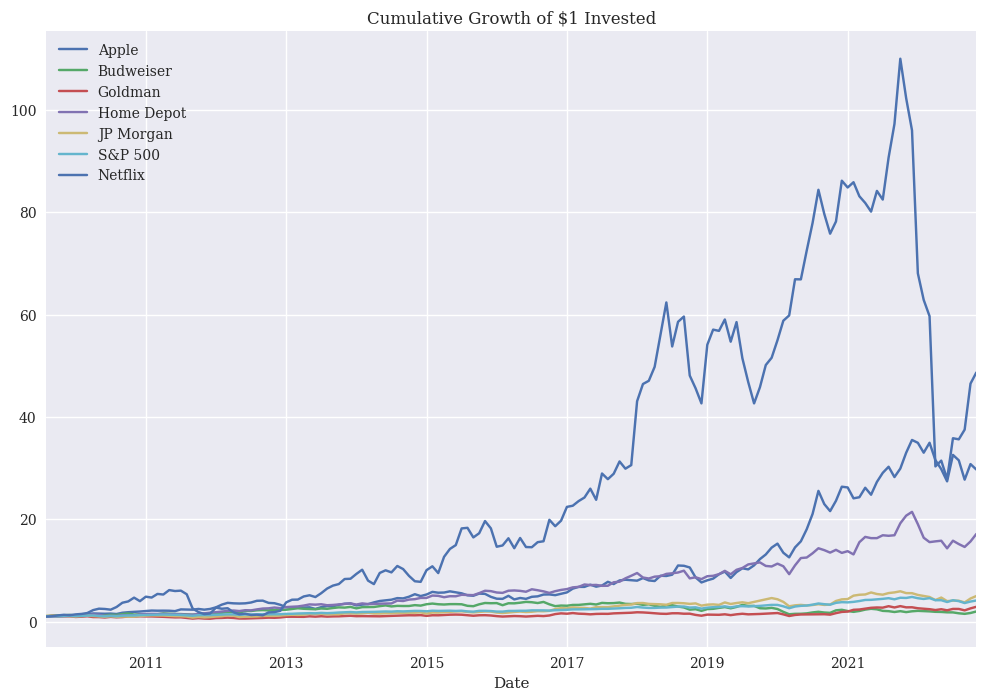

In [98]:
((1+rets[['Apple','Budweiser','Goldman','Home Depot','JP Morgan','S&P 500','Netflix']]).cumprod()).plot(title = "Cumulative Growth of $1 Invested",figsize=(12,8))

<AxesSubplot:title={'center':'Cumulative Growth of $1 Invested'}, xlabel='Date'>

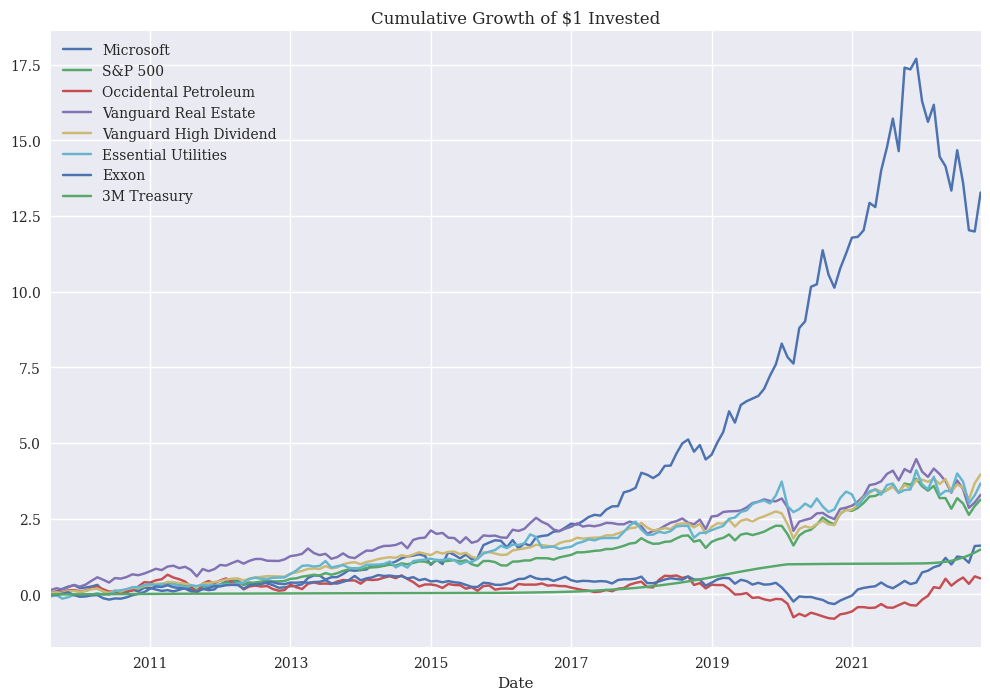

In [99]:
((((1+rets[['Microsoft','S&P 500', 'Occidental Petroleum','Vanguard Real Estate','Vanguard High Dividend','Essential Utilities','Exxon', '3M Treasury']])).cumprod())-1).plot(title = "Cumulative Growth of $1 Invested",figsize=(12,8))

In [100]:
cum_returns = (((1+rets).cumprod())-1)
cum_returns = pd.DataFrame((cum_returns.tail().max()).sort_values(ascending=False), columns = ['Cumaltive % Return'])
cum_returns

,Cumaltive % Return
Netflix,47.673417
Apple,31.571480
Home Depot,16.131567
Microsoft,14.678237
JP Morgan,4.002518
Essential Utilities,3.997796
Vanguard High Dividend,3.971194
Vanguard Real Estate,3.768827
S&P 500,3.182657
Goldman,1.898954


- The only two assets not returning back your money invested since 2003 is Budweiser and Occidental Petroleum. Netflix, if you got in early, would have returned you 47% gross return.At one point Netflix would have returned you an incredible $100$%.

- Over the entire period you actually earn more than Budweiser and Occidental by holding 3-Month Treasuy Bills.

# Univariate Risk Statistics

In [101]:
def performance_summary(return_data, annualization = 12):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*annualization)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(annualization))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']

    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [102]:
performance_summary(rets).sort_values(by = 'Sharpe Ratio', ascending=False)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
3M Treasury,0.068968,0.030312,2.275236,1.789315,2.813032,0.000050,0.000043,0.000000,2009-08-01,2009-08-01,2009-08-01
Home Depot,0.237138,0.212117,1.117959,-0.128209,0.773727,-0.062385,-0.121388,-0.332386,2021-12-01,2022-06-01,NaT
Apple,0.292956,0.270585,1.082677,-0.078656,-0.323692,-0.107935,-0.132282,-0.395421,2012-09-01,2013-06-01,2014-06-01
Microsoft,0.223910,0.215901,1.037095,0.019222,0.302928,-0.080505,-0.109113,-0.305285,2021-12-01,2022-10-01,NaT
Vanguard High Dividend,0.130539,0.139285,0.937210,-0.367450,1.684560,-0.050484,-0.088166,-0.238734,2019-12-01,2020-03-01,2020-12-01
S&P 500,0.117585,0.146521,0.802511,-0.391257,0.669672,-0.069521,-0.090002,-0.247695,2021-12-01,2022-09-01,NaT
Netflix,0.447962,0.563262,0.795300,0.749776,5.198140,-0.197629,-0.313974,-0.798966,2011-05-01,2012-09-01,2013-08-01
Essential Utilities,0.133595,0.186088,0.717912,-0.633430,1.123003,-0.092239,-0.126338,-0.215637,2021-12-01,2022-09-01,NaT
Vanguard Real Estate,0.126285,0.181909,0.694219,-0.351645,1.351806,-0.069824,-0.106075,-0.294162,2021-12-01,2022-09-01,NaT
JP Morgan,0.154486,0.256984,0.601153,-0.266175,0.971892,-0.101988,-0.161171,-0.367319,2021-10-01,2022-09-01,NaT


- Since 2003, Home Depot actually offers the highest sharpe ratio. Apple and Microsoft are greater than 1 as well. Sharpe is important for a variety of reasons because every investor wants to maximize return per risk invested. Even though Netflix averages an incredible 44% yearly return since 2003, it has an extreme amount of tail risk (**look at the excess Kurtosis; for a normally distributed random variable this measure should be 0**) because of the **streaming wars.** Some reasearch ought to go into who will win this battle in the long-run because the market punnished Netflix harshly as you can see that in the cumulative return chart.  

- Disregard the **High Sharpe Ratio for the the 3- Month Treasury Bills.**  They are risk-free for a reason and we expect them to have a high sharpe because their volatility ($\sigma$) is so low. 

- Also you can see that **a ton of assets were just at their peak in 2021/2020**. Now that central banks are raising rates at the fastest rate since the 1980s, global fight against inflation, European Energy Crisis, Ukraine-Russia War, Increased Global Debt, etc there has been a major sell off causing a lot more hightend risk than normal periods - more risk today than 2008 since the global financial crisis was just one **big thing** where now we have several major things to uncover. 

# Performance Summary at Different Times

In [103]:
performance_summary(rets['2014']).sort_values(by = 'Sharpe Ratio', ascending = False)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
3M Treasury,0.002450,0.000424,5.773102,0.408234,-0.459639,0.000041,0.000030,0.000000,2014-01-01,2014-01-01,2014-01-01
Microsoft,0.249793,0.092978,2.686575,0.540554,1.054692,-0.017960,-0.022318,-0.022318,2014-11-01,2014-12-01,NaT
Vanguard Real Estate,0.280149,0.147325,1.901572,-0.156599,2.287083,-0.031932,-0.069060,-0.069060,2014-08-01,2014-09-01,2014-10-01
Apple,0.369116,0.224110,1.647029,-1.126675,0.656993,-0.085790,-0.107697,-0.067867,2014-11-01,2014-12-01,NaT
Vanguard High Dividend,0.131268,0.084424,1.554872,-0.624115,-1.189972,-0.024888,-0.031597,-0.019398,2014-11-01,2014-12-01,NaT
Home Depot,0.284507,0.198782,1.431255,0.932757,1.622693,-0.047384,-0.062089,-0.035353,2014-02-01,2014-03-01,2014-08-01
S&P 500,0.111364,0.081089,1.373352,-0.443025,-0.415766,-0.024545,-0.035583,-0.015514,2014-08-01,2014-09-01,2014-10-01
Essential Utilities,0.165102,0.179835,0.918078,-0.310290,1.459179,-0.070846,-0.093059,-0.096389,2014-06-01,2014-09-01,2014-10-01
Goldman,0.109745,0.121559,0.902814,-1.233188,1.633314,-0.046885,-0.074128,-0.036651,2014-02-01,2014-05-01,2014-06-01
JP Morgan,0.103956,0.141765,0.733301,-0.925389,0.826280,-0.064404,-0.077911,-0.078896,2014-03-01,2014-05-01,2014-09-01


In [105]:
performance_summary(rets['2011']).sort_values(by = 'Sharpe Ratio', ascending = False)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
3M Treasury,0.006050,0.001778,3.403024,0.957466,-0.579768,0.000050,0.000050,0.000000,2011-01-01,2011-01-01,2011-01-01
Home Depot,0.225316,0.167197,1.347608,0.556801,-1.134218,-0.035570,-0.044374,-0.103544,2011-02-01,2011-09-01,2011-11-01
Apple,0.247797,0.203959,1.214932,1.238375,2.104478,-0.044330,-0.055784,-0.055784,2011-10-01,2011-11-01,2011-12-01
Exxon,0.188413,0.188266,1.000784,-0.014700,-1.060802,-0.060735,-0.072315,-0.164306,2011-04-01,2011-09-01,NaT
Vanguard High Dividend,0.107376,0.130652,0.821848,0.598207,0.533747,-0.037810,-0.049388,-0.116716,2011-04-01,2011-09-01,NaT
Budweiser,0.099992,0.182112,0.549070,0.973341,0.193605,-0.041029,-0.041260,-0.155979,2011-04-01,2011-09-01,NaT
Vanguard Real Estate,0.109519,0.242202,0.452181,0.251626,0.835163,-0.083553,-0.116994,-0.181503,2011-05-01,2011-09-01,NaT
Essential Utilities,0.012711,0.093076,0.136567,0.110299,-1.449027,-0.032512,-0.037762,-0.072938,2011-01-01,2011-07-01,NaT
Occidental Petroleum,0.050439,0.425571,0.118521,1.221659,2.757102,-0.143150,-0.175698,-0.371549,2011-04-01,2011-09-01,NaT
S&P 500,0.011461,0.159740,0.071750,0.756211,1.932291,-0.063528,-0.071762,-0.170276,2011-04-01,2011-09-01,NaT


In [110]:
performance_summary(rets['2012'])

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
Apple,0.325955,0.303115,1.075349,0.274175,-0.437920,-0.096044,-0.107600,-0.198620,2012-09-01,2012-12-01,NaT
Budweiser,0.409149,0.221021,1.851178,1.022574,0.792069,-0.034612,-0.046897,-0.048207,2012-03-01,2012-05-01,2012-06-01
Goldman,0.419368,0.343222,1.221854,-0.225919,1.600729,-0.116783,-0.168910,-0.230522,2012-03-01,2012-05-01,2012-12-01
Home Depot,0.427099,0.165073,2.587330,-0.893991,-0.619493,-0.046150,-0.047307,-0.047307,2012-04-01,2012-05-01,2012-06-01
JP Morgan,0.372706,0.350009,1.064847,-1.434633,3.190507,-0.136533,-0.223662,-0.274315,2012-03-01,2012-05-01,NaT
Microsoft,0.079006,0.223923,0.352827,0.504192,-0.020213,-0.076773,-0.088382,-0.163913,2012-03-01,2012-11-01,NaT
Netflix,0.674713,1.000125,0.674628,1.334591,1.918283,-0.251130,-0.303373,-0.547088,2012-01-01,2012-09-01,NaT
Occidental Petroleum,-0.152304,0.227860,-0.668410,-0.265243,-0.774067,-0.107116,-0.131002,-0.265870,2012-02-01,2012-11-01,NaT
Vanguard Real Estate,0.168862,0.119326,1.415126,0.021392,-0.449892,-0.034783,-0.045059,-0.045059,2012-04-01,2012-05-01,2012-07-01
Vanguard High Dividend,0.121729,0.081578,1.492170,-1.160909,2.082760,-0.024857,-0.046636,-0.046636,2012-04-01,2012-05-01,2012-07-01


# Measure Assets For Sytematic and Idiosyncratic Risk

- Here I'll regress each asset in your portfolio to get a better understanding if your asset is generating excess return over the market - **on average**.
- The regression equation:

    $r_{i,t} = \alpha + \beta*r_{\text{SPY},t} + \epsilon_t$

    - Will calculate the the Treynor ratio, Information Ratio, Tracking Error, and Market Beta (i,e, *systematic risk*)

In [115]:
assets = rets.columns
market = rets['S&P 500']
risk_free = rets['3M Treasury']

df_list = []
for stock in assets:
    stock_ret = rets[stock]
    reg = regression_based_performance(market, stock_ret, risk_free)
    beta = reg[0][0]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    tracking_error = np.round(reg[5],4)
    df_list.append(pd.DataFrame([[beta,treynor_ratio,information_ratio,alpha,r_squared, tracking_error]],columns=['Market Beta','Treynor Ratio','Information Ratio','Alpha','r_squared', 'tracking error'], index = [stock]))
reg_performance = pd.concat(df_list)

reg_performance.sort_values(by  = 'Alpha', ascending = False)




,Market Beta,Treynor Ratio,Information Ratio,Alpha,r_squared,tracking error
Netflix,1.129415,0.335567,0.585360,0.026263,0.086315,0.5384
Apple,1.134499,0.197434,0.747319,0.013296,0.377397,0.2135
Home Depot,1.003809,0.167532,0.779260,0.009925,0.480785,0.1528
Microsoft,0.991562,0.156260,0.671973,0.008943,0.452824,0.1597
3M Treasury,-0.007396,-0.000000,2.305402,0.005820,0.001278,0.0303
Essential Utilities,0.644609,0.100258,0.360481,0.004817,0.257605,0.1603
Vanguard High Dividend,0.887265,0.069394,0.524256,0.002184,0.871161,0.0500
Vanguard Real Estate,0.906989,0.063195,0.158084,0.001636,0.533693,0.1242
JP Morgan,1.274364,0.067107,0.026285,0.000387,0.527927,0.1766
S&P 500,1.000000,0.048617,0.000000,0.000000,1.000000,0.0000


- Most assets generate a **positive alpha** in this time period. *Goldman* has the highest systematic risk with a beta coeffcient of 1.129. 
- ALl of these statistics are scaled to a yearly basis. 

# Correlation Heat Map

Text(0.5, 1.0, 'Asset Correlation Heat Map')

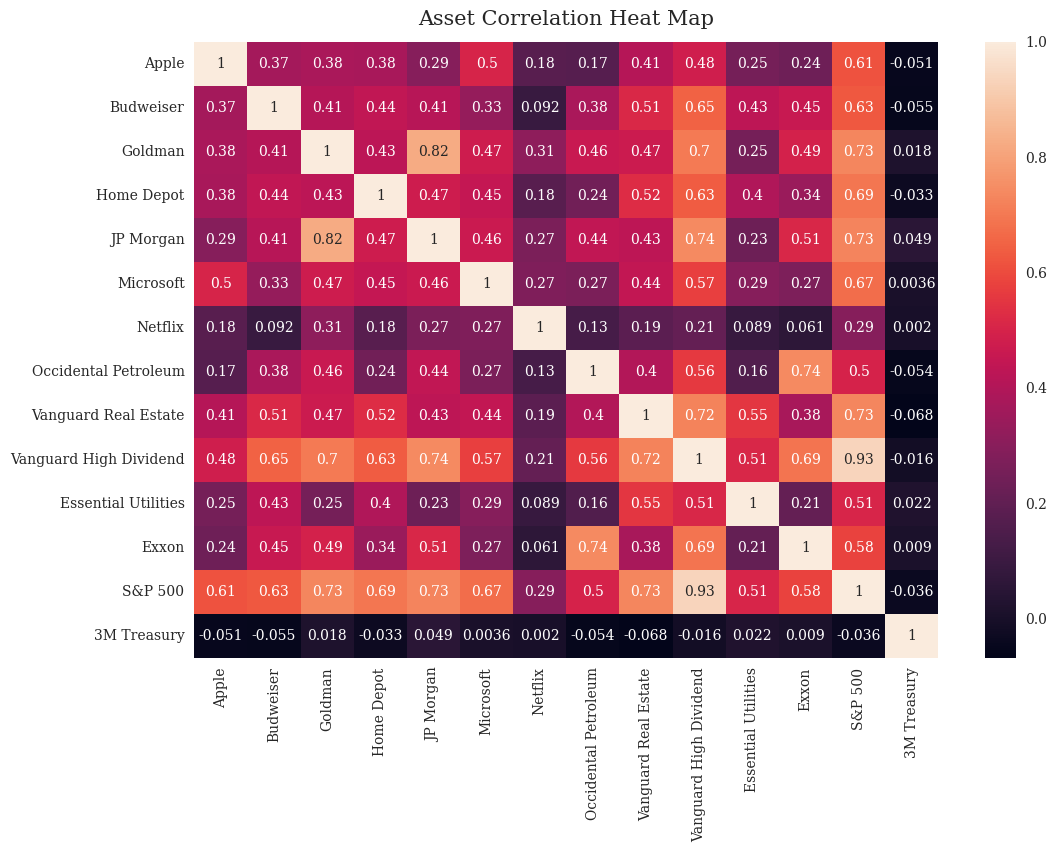

In [125]:
asset_corr = rets.corr()

plt.figure(figsize = (12,8))
heatmap = sns.heatmap(asset_corr,vmax = 1,annot = True)
heatmap.set_title("Asset Correlation Heat Map", fontdict={'fontsize':15}, pad = 12)

In [141]:
sorted_corr = asset_corr.unstack().sort_values().to_frame('Correlations')
sorted_corr = sorted_corr[sorted_corr['Correlations'] != 1]
sorted_corr.nlargest(len(rets.columns), 'Correlations')

,,Correlations
S&P 500,Vanguard High Dividend,0.933360
Vanguard High Dividend,S&P 500,0.933360
JP Morgan,Goldman,0.823563
Goldman,JP Morgan,0.823563
Exxon,Occidental Petroleum,0.740122
Occidental Petroleum,Exxon,0.740122
Vanguard High Dividend,JP Morgan,0.738585
JP Morgan,Vanguard High Dividend,0.738585
Goldman,S&P 500,0.731361
S&P 500,Goldman,0.731361


In [142]:
sorted_corr.nsmallest(len(rets.columns), 'Correlations')

Correlations
Vanguard Real Estate   3M Treasury                -0.067830
3M Treasury            Vanguard Real Estate       -0.067830
                       Budweiser                  -0.055113
Budweiser              3M Treasury                -0.055113
Occidental Petroleum   3M Treasury                -0.053701
3M Treasury            Occidental Petroleum       -0.053701
                       Apple                      -0.050922
Apple                  3M Treasury                -0.050922
S&P 500                3M Treasury                -0.035752
3M Treasury            S&P 500                    -0.035752
                       Home Depot                 -0.032992
Home Depot             3M Treasury                -0.032992
Vanguard High Dividend 3M Treasury                -0.016380
3M Treasury            Vanguard High Dividend     -0.016380